In [1]:
import re
import os
import sys
import math
import time
import pymbar
import natsort
import itertools
import numpy as np
import pandas as pd
from copy import copy
from glob import glob
import matplotlib as mpl
from typing import Literal
from typing import get_args
from scipy import integrate
import scipy.optimize as opt
from pymbar import timeseries
import matplotlib.pyplot as plt
from matplotlib.cm import magma
from matplotlib.cm import viridis
from scipy.special import logsumexp
from scipy.ndimage import gaussian_filter
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.cm.viridis.colors[::25])

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


In [2]:
pymbar.__version__

'4.0.1'

In [3]:
class ARW_FE_analysis():
    def __init__(self, fileglob, CV_columnList, T, nbins, subset=0, forceConstantCorrectionFactor=0.5):
        self.subset = subset
        self.kB = 0.001987204259       # kB in kcal/mol/K ambers standard energy unit
        self.Temperature = T
        self.Beta = 1.0 / (self.kB * self.Temperature)
        self.files = glob(fileglob)
        self.hamiltonians = len(self.files)
        self.hamiltonianTemperatures = np.ones(self.hamiltonians,float)*T
        self.CV_columnList = CV_columnList
        self.CV_columnCount = len(CV_columnList)
        self.hamiltonianBetas = 1.0 / (self.kB * self.hamiltonianTemperatures)
        self.hamiltoniansAnchorPattern = r'anchor\({}\).* position = .?\d*.\d+,\s+(.?\d*.\d*),\s+(.?\d*.\d+),\s+.?\d*.\d+'
        self.hamiltoniansForceRegex = re.compile(r'strength = (\d*.\d+),\s+(\d*.\d*)')
        self.hamiltonianForces = np.zeros(self.hamiltonians, np.float64)
        self.hamiltonianAnchors = np.zeros(self.hamiltonians, np.float64)
        self.Hamiltonians_CVs = 0
        self.hamiltonianSamplesizes = 0
        self.cvmin = 0
        self.cvmax = 0
        self.nbins = nbins
        self.forceConstantCorrectionFactor = forceConstantCorrectionFactor
        
# 2. Read in data and meta data of files or Read in CV data
    def read_cvdata_from_pmdout(self):
        """
        Read and process collective variable (CV) data from PMD output files.

        This method reads collective variable data from PMD output files and performs
        necessary preprocessing. It supports both single-column and multi-column CV data.

        Returns:
        --------
        None

        Description:
        ------------
        - For single-column CVs (self.CV_columnCount == 1):
            - It extracts the anchor positions and forces for each simulation file.
            - Reads the CV data, extracts the specified column, and stores it.
            - Orders the CV data based on the mean values.

        - For multi-column CVs (self.CV_columnCount > 1):
            - It iteratively extracts anchor positions and forces for each column.
            - Reads the CV data, extracts the specified columns, and stores them.
            - Organizes the CV data into an array structure for further analysis.

        The processed CV data and associated information are stored in class attributes:
        - self.Hamiltonians_CVs: Processed CV data for each hamiltonian of the simulation (assuming HREUS simulation).
        - self.hamiltonianSamplesizes: Sample sizes for each Hamiltonian CVs.
        - self.hamiltonianForces: Force constants for each Hamiltonian CVs.
        - self.hamiltonianAnchors: Anchor positions for each Hamiltonian CVs.
        
        These four attributes are crucial for calculating the energies to input in PYMBAR which in turn
        calculates the free energies associated with the respective system.

        Note:
        - This method assumes that the class attributes, such as self.files and 
          self.CV_columnList have been properly initialized during instantiation.
        - The subset of data to consider (e.g., last N data points) is controlled by self.subset.
        - Make sure the method is called after initializing the ARW_FE_analysis class with
          relevant parameters and file paths.

        Example:
        --------
        # Initialize the class instance with necessary parameters and file paths
        my_instance = ARW_FE_analysis(...)
        # Read and process the CV data from PMD output files
        my_instance.read_cvdata_from_pmdout()
        """
        
        CV_rawlist = []
        CV_minimas = [] ### they are not really necessary I guess...not used for anything
        CV_maximas = [] ### they are not really necessary I guess... not used for anything
        
        if self.CV_columnCount == 1:
            hamiltoniansAnchorRegex = re.compile(self.hamiltoniansAnchorPattern.format(self.CV_columnList[0]))

            # iterate through files to read the meta data (centers and spring constants)
            for i, CV_outputFile in enumerate(self.files):
                print('reading file with the filename {}'.format(CV_outputFile))
                # read the file and try to find the regex expression in each line
                with open(CV_outputFile) as fn:
                    for line in fn:
                        try:
                            cvAnchor1, cvAnchor2 = re.search(hamiltoniansAnchorRegex, line).group(1,2)
                            cvForce1, cvForce2 = re.search(self.hamiltoniansForceRegex, next(fn)).group(1,2)
                            self.hamiltonianAnchors[i] = float(cvAnchor1)
                            self.hamiltonianForces[i] = float(cvForce1) * self.forceConstantCorrectionFactor
                            break
                        except AttributeError:
                            # I forgot why this was important... but it was!
                            pass

                    if cvAnchor1 != cvAnchor2 or cvForce1 != cvForce2:
                        raise ValueError('the reference positions r2, r3 or the force constants of each harmonic restraint contribution are not identical. WHAM only works for harmonic restraints. ')

                CV_rawdata = pd.read_csv(CV_outputFile, 
                                         delim_whitespace=True,
                                         comment='#',
                                         header=None,
                                         usecols=self.CV_columnList)
                CV_rawlist.append(CV_rawdata.loc[:,self.CV_columnList[0]].values[-self.subset:]) 

                CV_minimas.append(CV_rawdata.loc[:,self.CV_columnList[0]].values.min())### they are not really necessary I guess...not used for anything
                CV_maximas.append(CV_rawdata.loc[:,self.CV_columnList[0]].values.max())### they are not really necessary I guess...not used for anything
            self.Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0)))
            self.Hamiltonians_CVs[~np.isfinite(self.Hamiltonians_CVs)] = 0
            self.hamiltonianSamplesizes = np.array([cv.shape[0] for cv in CV_rawlist])        
            collectiveVariableOrder = np.argsort(np.array([cv[cv != 0].mean() for cv in self.Hamiltonians_CVs]))
            
            ### CV output files should be assignable to Hamiltonians, so sorting them in the same way would be nice, maybe also for multi cv but we will see...
            self.Hamiltonians_CVs = self.Hamiltonians_CVs[collectiveVariableOrder]
            self.hamiltonianForces = self.hamiltonianForces[collectiveVariableOrder]
            self.hamiltonianAnchors = self.hamiltonianAnchors[collectiveVariableOrder]
            self.hamiltonianSamplesizes = self.hamiltonianSamplesizes[collectiveVariableOrder]
        
        if self.CV_columnCount > 1:
            Hamiltonians_CVs = []
            hamiltonianAnchors = []
            hamiltonianForces = []
            
            # iterate through files to read the meta data (centers and spring constants)
            for i, CV_outputFile in enumerate(self.files):
                print('reading file with the filename {}'.format(CV_outputFile))
                # read the file and try to find the regex expression in each line
                for CV_column in self.CV_columnList:
                    
                    hamiltoniansAnchorRegex = re.compile(self.hamiltoniansAnchorPattern.format(CV_column))
                    
                    with open(CV_outputFile) as fn:
                        for line in fn:
                            try:    
                                cvAnchor1, cvAnchor2 = re.search(hamiltoniansAnchorRegex, line).group(1,2)
                                cvForce1, cvForce2 = re.search(self.hamiltoniansForceRegex, next(fn)).group(1,2)
                                hamiltonianAnchors.append(float(cvAnchor1))
                                hamiltonianForces.append(float(cvForce1))
                                break
                            except AttributeError:
                                # I forgot why this was important... but it was!
                                pass

                    if cvAnchor1 != cvAnchor2 or cvForce1 != cvForce2:
                        raise ValueError('the reference positions r2, r3 or the force constants of each harmonic restraint contribution are not identical. WHAM only works for harmonic restraints. ')

                CV_rawdata = pd.read_csv(CV_outputFile, 
                                         delim_whitespace=True,
                                         comment='#',
                                         header=None,
                                         usecols=self.CV_columnList)
                CV_rawlist.append(CV_rawdata.loc[:,self.CV_columnList].values[-self.subset:].T)
                CV_minimas.append(CV_rawdata.loc[:,self.CV_columnList].values.min())### they are not really necessary I guess...not used for anything
                CV_maximas.append(CV_rawdata.loc[:,self.CV_columnList].values.max())### they are not really necessary I guess...not used for anything
                 
            Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0)))
            Hamiltonians_CVs[~np.isfinite(Hamiltonians_CVs)] = 0
            flatHamiltonians_CVs = Hamiltonians_CVs.reshape(self.hamiltonians*self.CV_columnCount, -1)
            self.hamiltonianSamplesizes = np.array([cv.shape[0] for cv in flatHamiltonians_CVs])
            self.Hamiltonians_CVs = Hamiltonians_CVs.reshape(self.hamiltonians, self.CV_columnCount, -1)
            self.hamiltonianForces = np.array(hamiltonianForces).reshape(self.hamiltonians,-1)
            self.hamiltonianAnchors = np.array(hamiltonianAnchors).reshape(self.hamiltonians,-1)
        
# 2.5 Decorrelate data
    
    def logistic(self, x, a, k):
        """
        Compute the logistic function with a forced crossing point at (1, 0).

        Parameters:
        ----------
        x : float or array-like
            The input values where the function is evaluated.
        a : float
            The amplitude or maximum value of the logistic curve.
        k : float
            The steepness or growth rate of the curve.

        Returns:
        -------
        y : float or array-like
            The computed values of the logistic function at the given input(s).

        Note:
        -----
        The logistic function is forced to cross the point (1, 0) to fit a specific 
        curve (BSE curve) with the aim to find the minimum of the second derivative.
        This gives the point of minimal acceleration hence, the onset of the plateau
        region which can be used as a measure of correlation time for a given 
        correlated data set.

        Example usage:
        --------------
        >>> print(logistic(x=2.0, a=3.0, k=1.5))
        2.4341309515323876
        """
        return a / (1. + np.exp(-k * (x - 1))) - 0.5 * a
    
    def d2logistic_dx2(self, x, a, k):   # 2nd derivative of the logistic function above necessary for fitting a BSE curve
        """
        Compute the second derivative of the logistic function with a forced crossing point at (1, 0).

        The second derivative of the logistic function is calculated as follows (latex formula):
        f''(x) = -a k^2 \frac{e^{k (x - 1)} - 1}{(e^{k (x - 1)} + 1)^3}

        Parameters:
        ----------
        x : float or array-like
            The input values where the second derivative is evaluated.
        a : float
            The amplitude or maximum value of the logistic curve.
        k : float
            The steepness or growth rate of the curve.

        Returns:
        -------
        d2y_dx2 : float or array-like
            The computed values of the second derivative of the logistic function at the given input(s).

        Note:
        -----
        The second derivative of the logistic function is necessary for fitting a specific curve (BSE curve).

        Example usage:
        --------------
        >>> result = d2logistic_dx2(x=2.0, a=3.0, k=1.5)
        >>> print(result)
        0.22248745418814167
        """
        return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3
        
    ### implement a safety factor to multiplicate the t_corr estimate with
    def correlationTime_from_BSE(self, hamiltonian, minimumIndependentCVs=1000, safetyFactor=2.0,showBSEplots=True):
        """
        Estimate the correlation time from a Blocked Standard Error (BSE) analysis for a dataset
        specified by its system's Hamiltonian. This method calculates the correlation time of a
        dataset using a BSE analysis. It performs blocking of data and calculates the blocked 
        standard deviation for various blocksizes in accordance with 'Quantifying uncertainty 
        and sampling quality in biomolecular simulations' by Grossfield and Zuckerman. For a 
        quantitative estimate a logistic function is fitted to the BSE curve, and estimates the 
        correlation time based on the inflection point of the second derivative of the logistic fit.
        The dataset is part of the class instance. It is stored in the self.Hamiltonians_CVs attribute.

        Parameters:
        ----------
        hamiltonian : int
            Index of the Hamiltonian for which the correlation time is estimated.
        minimumIndependentCVs : int, optional
            The minimum number of independent data points to consider for blocking analysis (default is 1000).
        safetyFactor : float, optional
            Factor to multiply the correlation time estimate with to ensure proper decorrelation (default is 2.0).
        showBSEplots : bool, optional
            Whether to display BSE analysis plots (default is True).

        Returns:
        -------
        correlationTimeEstimate : int
            The estimated correlation time for the given Hamiltonian.

        Note:
        -----
        - The method relies on a logistic function and its second derivative to fit the BSE curve.
        - The correlation time estimate is based on the minimum of the second derivative.
        - If `showBSEplots` is True, BSE analysis plots will be displayed. This plot contains BSE data,
        Gaussian smooth of BSE Data, Logistic Fit, Second Derivative and vertical line at t_corr.
        - Usually, the method is not called directly from the command line, but is called by self.decorr_cv_H()

        Example usage:
        --------------
        >>> arw_analysis = ARW_FE_Analysis()
        >>> correlation_time = arw_analysis.correlationTime_from_BSE(5, minimumIndependentCVs=500)
        >>> print(correlation_time)
        42
        """
        blockedStandardErrorsList = []

        CVs_hamiltonian = self.Hamiltonians_CVs[hamiltonian]
        CVs_hamiltonian = CVs_hamiltonian[CVs_hamiltonian != 0]
        ### Friederike encountered a problem where she had too less independent samples. So I should make sure, that correlationTime_from_BSE throws an error, if maximumblocksize 
        ### is smaller than a certain value. lets say 20 or so. I should give this some though.
        CVsampleSize = CVs_hamiltonian.shape[0]
        maximumBlockSize = int(np.round(CVsampleSize / minimumIndependentCVs))

        for blockSize in range(1,maximumBlockSize):
            excludedSamples = CVsampleSize % blockSize   # to screen all integer blocksizes the first couple of CV sampes need to be excluded sometimes
            blockedAverages = np.mean(np.reshape(CVs_hamiltonian[excludedSamples:], (-1, blockSize)), axis=0)
            blockedStandardError = np.std(blockedAverages)
            blockedStandardErrorsList.append(blockedStandardError / np.sqrt(blockSize))

        BSE = np.array(blockedStandardErrorsList)
        blockSizes = np.arange(BSE.shape[0])

        (logisticAmplitude, logisticGrowthRate), _ = opt.curve_fit(self.logistic, blockSizes, BSE)
        BSE_fit = self.logistic(blockSizes,
                                logisticAmplitude,
                                logisticGrowthRate)
        BSE_fit_2nd_derivative = self.d2logistic_dx2(blockSizes, logisticAmplitude, logisticGrowthRate)
        correlationTimeEstimate = np.argsort(BSE_fit_2nd_derivative)[0]    # grossfield et al: t_corr = 2 * inflection_point; but whatever
        
        if showBSEplots:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
            ax2 = ax.twinx()   # twin axis, since the second derivative is usually very small
            data = ax.plot(blockSizes, BSE, alpha=0.7, label='data')
            logfit = ax.plot(blockSizes, BSE_fit, label='logistic fit')
            gauss = ax.plot(blockSizes, gaussian_filter(BSE, sigma=10), linestyle='--', linewidth=0.7, label='gaussian smooth')
            deriv = ax2.plot(blockSizes, BSE_fit_2nd_derivative, c='r', linestyle='-.', label='2nd derivative')
            vline = ax.plot((correlationTimeEstimate, correlationTimeEstimate), (BSE.min(), BSE.max()),
                            linewidth=0.5,
                            color='black',
                            label='t_corr')

            lines = data+logfit+gauss+deriv+vline    # label collection crucial for ax.twinx()
            labels = [line.get_label() for line in lines]

            ax.set_title('BSE analysis for hamiltonian {} (t_corr={})'.format(hamiltonian,correlationTimeEstimate))
            ax.legend(lines, labels)
            plt.show()
            
        return correlationTimeEstimate * safetyFactor

    def decorr_cv_H(self, minimumIndependentCVs=1000, correlationTimeEstimate=None, safetyFactor=2.0, showBSEplots=True):
        """
        Decorrelate the Hamiltonian-related collective variables (CVs) for improved free energy calculation.

        This method decorrelates the CVs associated with different Hamiltonians by subsampling them based on
        the estimated correlation time obtained from a Blocked Standard Error (BSE) analysis or from user input.
        The decorrelation process helps in generating more independent samples for each Hamiltonian.

        Parameters:
        ----------
        minimumIndependentCVs : int, optional
            The minimum number of independent data points to consider for blocking analysis (default is 1000).
        correlationTimeEstimate : int, optional
            Precomputed correlation time estimate; if provided, it will be used for decorrelation (default is None).
        safetyFactor : float, optional
            Multiplication factor that is applied to the respective correlation time estimate (default is 2.0).
        showBSEplots : bool, optional
            Whether to display BSE analysis plots during correlation time estimation (default is True).

        Returns:
        -------
        HamiltoniansDecorrelatedCVs : ndarray
            Decorrelated CVs for each Hamiltonian.
        hamiltoniansDecorrelatedSamplesizes : list
            List of sample sizes after decorrelation for each Hamiltonian.

        Note:
        -----
        - If `correlationTimeEstimate` is not provided, the method estimates correlation times using the BSE analysis.
        - The method subsamples CVs to achieve decorrelation based on the estimated correlation times.
        - The decorrelation process results in updated CVs and sample sizes.
        - If `showBSEplots` is True, BSE analysis plots may be displayed during correlation time estimation.

        Example usage:
        --------------
        >>> arw_analysis = ARW_FE_Analysis(...)
        >>> decorrelated_CVs, decorrelated_sample_sizes = arw_analysis.decorr_cv_H(minimumIndependentCVs=500)
        >>> print(decorrelated_CVs)
        array([[1.23, 2.34, 3.45, ...],
               [0.98, 1.67, 2.89, ...],
               ...
               [2.01, 3.12, 4.53, ...]])
        >>> print(decorrelated_sample_sizes)
        [890, 921, 879, ...]
        """
        hamiltoniansDecorrelatedSamplesizes = copy(self.hamiltonianSamplesizes)
        HamiltoniansDecorrelatedCVs = copy(self.Hamiltonians_CVs)
        if correlationTimeEstimate==None:
            for hamiltonian, _ in enumerate(self.Hamiltonians_CVs):
                correlationTimeEstimate = self.correlationTime_from_BSE(hamiltonian,
                                                                        safetyFactor=safetyFactor,
                                                                        minimumIndependentCVs=minimumIndependentCVs,
                                                                        showBSEplots=showBSEplots)                                
                decorrelatedCVsamplesize = int(self.hamiltonianSamplesizes[hamiltonian] / correlationTimeEstimate)
                highestCVsampleIndex = self.hamiltonianSamplesizes[hamiltonian]
                ### np.sort() is untested
                randomDecorrelatedIndices = np.sort(np.random.randint(highestCVsampleIndex, size=decorrelatedCVsamplesize))
                hamiltoniansDecorrelatedSamplesizes[hamiltonian] = randomDecorrelatedIndices.shape[0]
                HamiltoniansDecorrelatedCVs[hamiltonian, 0:hamiltoniansDecorrelatedSamplesizes[hamiltonian]] = self.Hamiltonians_CVs[hamiltonian, randomDecorrelatedIndices]
                print("Correlation time for set {} is {}".format(hamiltonian, correlationTimeEstimate))
        else:
            for hamiltonian, _ in enumerate(self.Hamiltonians_CVs):
                decorrelatedCVsamplesize = int(hamiltoniansDecorrelatedSamplesizes[hamiltonian]/correlationTimeEstimate)
                highestCVsampleIndex = hamiltoniansDecorrelatedSamplesizes[hamiltonian]
                randomDecorrelatedIndices = np.random.randint(highestCVsampleIndex, size=decorrelatedCVsamplesize)
                hamiltoniansDecorrelatedSamplesizes[hamiltonian] = randomDecorrelatedIndices.shape[0]
                HamiltoniansDecorrelatedCVs[hamiltonian,:hamiltoniansDecorrelatedSamplesizes[hamiltonian]] = self.Hamiltonians_CVs[hamiltonian, randomDecorrelatedIndices]
                
        return HamiltoniansDecorrelatedCVs, hamiltoniansDecorrelatedSamplesizes
            
        
# 3. calculate energies
    def calc_free_energies(self, decorrelationRequired=False, minimumIndependentCVs=1000, correlationTimeEstimate=None, showBSEplots=True):
        
        solver_protocol = (dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=1000,min_sc_iter=5)),
                           dict(method="hybr"),
                           dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=10000,min_sc_iter=5)))
        
        if decorrelationRequired:
            self.Hamiltonians_CVs, self.hamiltonianSamplesizes = self.decorr_cv_H(minimumIndependentCVs=minimumIndependentCVs, 
                                                                                               correlationTimeEstimate=correlationTimeEstimate,
                                                                                               showBSEplots=showBSEplots)
        else:
            print("Caution, You might be using correlated Data.")
            
        MaximumSampleSize = self.hamiltonianSamplesizes.max()
        Hamiltonians_CVs_energies = (self.hamiltonianBetas[None,:,None] 
                                    *self.hamiltonianForces[None,:, None]
                                    *(self.Hamiltonians_CVs[:,None,:MaximumSampleSize] - self.hamiltonianAnchors[:,None])**2)
        ### Do not forget to swap the axis of Hamiltonians_CVs_energies! 
        self.collectiveVariablesFlat = pymbar.utils.kn_to_n(self.Hamiltonians_CVs, N_k=self.hamiltonianSamplesizes)
        self.cvmin = np.ceil(self.collectiveVariablesFlat.min() * 100) / 100
        self.cvmax = np.floor(self.collectiveVariablesFlat.max() * 100) / 100
        
        self.bin_centers = np.linspace(self.cvmin, self.cvmax, self.nbins*2+1)[1::2]
        self.bin_edges = np.linspace(self.cvmin, self.cvmax, self.nbins+1)

        self.histo_params = {}
        self.histo_params["bin_edges"] = self.bin_edges
        self.fes = pymbar.FES(Hamiltonians_CVs_energies,
                              self.hamiltonianSamplesizes,
                              verbose=True,
                              mbar_options=dict(solver_protocol=solver_protocol))
        print("FES succesfully calculated")
    
    def calc_MBAR_free_energy_differences(self, angularData=False,decorrelationRequired=False, minimumIndependentCVs=1000, correlationTimeEstimate=None, showBSEplots=True):
        
        solver_protocol = (dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=1000,min_sc_iter=5)),
                           dict(method="hybr"),
                           dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=10000,min_sc_iter=5)))
        if angularData:
            self.Hamiltonians_CVs = np.exp(1j*self.Hamiltonians_CVs)
        if decorrelationRequired:
            self.Hamiltonians_CVs, self.hamiltonianSamplesizes = self.decorr_cv_H(minimumIndependentCVs=minimumIndependentCVs, 
                                                                                               correlationTimeEstimate=correlationTimeEstimate,
                                                                                               showBSEplots=showBSEplots)
        else:
            print("Caution, You might be using correlated Data.")
            
        MaximumSampleSize = self.hamiltonianSamplesizes.max()

        if angularData:
            Hamiltonians_CVs_energies = (self.hamiltonianBetas[None,:,None] 
                                        *self.hamiltonianForces[None,:, None]
                                        *np.angle(self.Hamiltonians_CVs[:,None,:MaximumSampleSize] / np.exp(1j*self.hamiltonianAnchors[:,None]))**2)
        else:
            Hamiltonians_CVs_energies = (self.hamiltonianBetas[None,:,None] 
                                        *self.hamiltonianForces[None,:,None]
                                        *(self.Hamiltonians_CVs[:,None,:MaximumSampleSize] - self.hamiltonianAnchors[:,None])**2)
        ### Do not forget to swap the axis of Hamiltonians_CVs_energies! 
        self.mbar = pymbar.MBAR(Hamiltonians_CVs_energies,
                                self.hamiltonianSamplesizes,
                                verbose=True,
                                solver_protocol=solver_protocol)

        freeEnergyDifferences = self.mbar.compute_free_energy_differences()
        dimensionlessDelta_F = freeEnergyDifferences['Delta_f']
        dimensionlessDelta_F_Error = freeEnergyDifferences['dDelta_f']

        self.Delta_F = dimensionlessDelta_F * self.kB * self.Temperature
        self.Delta_F_Error = dimensionlessDelta_F_Error * self.kB * self.Temperature
        
    def plot_histograms(self, angularData=False):
        if self.CV_columnCount == 1:
            for cvSamples in self.Hamiltonians_CVs:
                if angularData: cvSamples = np.angle(cvSamples)
                plt.hist(cvSamples[cvSamples != 0],bins=200,alpha=0.5)[2]
            plt.show()
            
        elif self.CV_columnCount > 1:
            for columnID in range(self.CV_columnCount):
                for cvSamples in self.Hamiltonians_CVs[:,columnID,:]:
                    if angularData: cvSamples = np.angle(cvSamples)
                    plt.hist(cvSamples[cvSamples != 0],bins=200,alpha=0.5)[2]
                plt.show()
                
        
        
# 5. Calculate FE
    def create_PMF(self, show_pmf=True):
        Hamiltonians_energies = (self.hamiltonianBetas[:, None]
                                *self.hamiltonianForces[:, None]
                                *(self.Hamiltonians_CVs[:,:] - self.hamiltonianAnchors[:, None])**2)
        ### Do not forget to swap the axis of Hamiltonians_CVs_energies! 
        Hamiltonians_energies -= Hamiltonians_energies.min()
        self.fes.generate_fes(Hamiltonians_energies, self.collectiveVariablesFlat, fes_type="histogram", histogram_parameters=self.histo_params)
        MBARFreeEnergySurface = self.fes.get_fes(self.bin_centers, reference_point="from-lowest", uncertainty_method="analytical")
        
        dimensionless_PMF = MBARFreeEnergySurface["f_i"]
        dimensionless_dPMF = MBARFreeEnergySurface["df_i"]
        
        self.reactionCoordinate = self.bin_centers
        self.PMF = dimensionless_PMF * self.kB * self.Temperature
        self.dPMF = dimensionless_dPMF * self.kB * self.Temperature
        
        if show_pmf:
            plt.errorbar(self.reactionCoordinate, self.PMF, yerr=self.dPMF)
            plt.show()
        
    def calc_I_star(self, dissociationBoundary, show_pmf=True):
        try:
            dissociationBoundaryIndex = np.where(self.reactionCoordinate > dissociationBoundary)[0][0]
        except AttributeError: 
            self.create_PMF(show_pmf=show_pmf)
        
        self.rStar = self.reactionCoordinate[dissociationBoundaryIndex] ### mayvbe rename to r_star (I_star and S_star are also like that)
        Work_DissociationBoundary = self.PMF[dissociationBoundaryIndex]
        Work_PMF = self.PMF[:dissociationBoundaryIndex]

        boltzmannFactorDissociationWork = np.exp(-np.mean(self.hamiltonianBetas) * (Work_PMF - Work_DissociationBoundary))
        self.I_star = integrate.trapz(boltzmannFactorDissociationWork, 
                                      self.reactionCoordinate[:dissociationBoundaryIndex])
                
    
    def calc_S_star(self, r_star, k_phi=None, k_theta=None, theta0=None, phi0=None):

        def integrand(theta, phi):
            nonlocal phi0
            nonlocal k_phi
            nonlocal theta0
            nonlocal k_theta

            if phi0 == None: phi0 = self.hamiltonianAnchors[0][1]
            if k_phi == None: k_phi = self.hamiltonianForces[0][1]
            if theta0 == None: theta0 = self.hamiltonianAnchors[0][0]
            if k_theta == None: k_theta = self.hamiltonianForces[0][0]

            u_theta = k_theta * (theta0 - theta)**2
            u_phi = k_phi * (phi0 - phi)**2

            return(math.sin(theta) * math.exp(-self.Beta * (u_theta + u_phi)))

        integral, integral_error = integrate.nquad(integrand, [[0, math.pi],
                                                    [-math.pi,math.pi]])
        self.S_star = r_star**2 * integral
        self.S_star_Error = r_star**2 * integral_error

    
    def calc_G_oB(self, k_Theta=None, k_Phi=None, k_Psi=None, Theta0=None, Phi0=None, Psi0=None):

        def integrand(Theta, Phi, Psi):
            nonlocal Phi0
            nonlocal Psi0
            nonlocal Theta0
            
            nonlocal k_Phi
            nonlocal k_Psi
            nonlocal k_Theta

            if Theta0 == None: Theta0 = self.hamiltonianAnchors[0][0]
            if Phi0 == None: Phi0 = self.hamiltonianAnchors[0][1]
            if Psi0 == None: Psi0 = self.hamiltonianAnchors[0][2]
            
            if k_Theta == None: k_Theta = self.hamiltonianForces[0][0]
            if k_Phi == None: k_Phi = self.hamiltonianForces[0][1]
            if k_Psi == None: k_Psi = self.hamiltonianForces[0][2]

            u_Theta = k_Theta * (Theta0 - Theta)**2
            u_Phi = k_Phi * (Phi0 - Phi)**2
            u_Psi = k_Psi * (Psi0 - Psi)**2

            return(math.sin(Theta) * math.exp(-self.Beta * (u_Theta + u_Phi + u_Psi)))

        integral, integral_error = integrate.nquad(integrand, [[0,       math.pi],
                                                               [-math.pi,math.pi],
                                                               [-math.pi,math.pi]])        
        
        self.dG_oB = -self.kB * self.Temperature * np.log(integral / 8 / np.pi**2)
        self.dG_oB_Error = abs(-self.kB * self.Temperature / (integral * 8 * np.pi**2)) * integral_error
                           

    def compute_overlap_matrix(self, minimumIndependentCVs=100, correlationTimeEstimate=100, showBSEplots=False):
        ### the whole overlap matrix does not really contain a lot of informatio so it would make sense to just plot the first 5-6 highest values per line
        try:
            MbarOverlap = self.mbar.compute_overlap()
            plt.matshow(MbarOverlap['matrix'], vmin=0, vmax=1)
            return MbarOverlap
        
        except AttributeError:
            
            HamiltoniansDecorrelatedCVs, hamiltoniansDecorrelatedSamplesizes = self.decorr_cv_H(minimumIndependentCVs=minimumIndependentCVs,
                                                                                                correlationTimeEstimate=correlationTimeEstimate,
                                                                                                showBSEplots=showBSEplots)
            MaximumSampleSize = hamiltoniansDecorrelatedSamplesizes.max()
            # cv_sort = np.argsort(self.cvs_H.mean(axis=1))
            Hamiltonians_CVs_energies = (self.hamiltonianBetas[None,:,None]
                                        *self.hamiltonianForces[None,:, None]
                                        *(HamiltoniansDecorrelatedCVs[:,None,:MaximumSampleSize] - self.hamiltonianAnchors[:,None])**2)

            MBAR = pymbar.mbar.MBAR(Hamiltonians_CVs_energies, hamiltoniansDecorrelatedSamplesizes)
            MbarOverlap = MBAR.compute_overlap()
            plt.matshow(MbarOverlap['matrix'])
            return MbarOverlap
        
    
    
    def calc_MBAR_free_energy_differences_MultiCV(self, angularData=False, decorrelationRequired=False, minimumIndependentCVs=1000, correlationTimeEstimate=None, showBSEplots=True):
        
        solver_protocol = (dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=1000,min_sc_iter=5)),
                           dict(method="hybr"),
                           dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=10000,min_sc_iter=5)))
        if angularData:
            self.Hamiltonians_CVs = np.exp(1j*self.Hamiltonians_CVs)
        
        if decorrelationRequired:
            self.Hamiltonians_CVs = self.Hamiltonians_CVs.reshape(self.hamiltonians*self.CV_columnCount,-1)
            HamiltoniansDecorrelatedCVs, hamiltoniansDecorrelatedSamplesizes = self.decorr_cv_H(minimumIndependentCVs=minimumIndependentCVs, 
                                                                                               correlationTimeEstimate=correlationTimeEstimate,
                                                                                               showBSEplots=showBSEplots)   
            self.Hamiltonians_CVs = HamiltoniansDecorrelatedCVs.reshape(self.hamiltonians, self.CV_columnCount, -1)
            self.hamiltonianSamplesizes = hamiltoniansDecorrelatedSamplesizes.reshape(self.hamiltonians, self.CV_columnCount)
            self.hamiltonianSamplesizes = np.min(self.hamiltonianSamplesizes, axis=1)
        else:
            print("Caution, You might be using correlated Data.")
            
        MaximumSampleSize = self.hamiltonianSamplesizes.max()

        Hamiltonians_CVs_energies = 0
        for columnID in range(self.CV_columnCount):
            singleColumnHamiltonians_CVs = self.Hamiltonians_CVs[:,columnID,:]
            singleColumnHamiltonianAnchors = self.hamiltonianAnchors[:,columnID]
            singleColumnHamiltonianForces = self.hamiltonianForces[:,columnID]

            if angularData:
                Hamiltonians_CVs_energies += (self.hamiltonianBetas[None,:,None] 
                                             *singleColumnHamiltonianForces[None,:, None]
                                             *np.angle(singleColumnHamiltonians_CVs[:,None,:MaximumSampleSize] / np.exp(1j*singleColumnHamiltonianAnchors[:,None]))**2)
            else:
                Hamiltonians_CVs_energies += (self.hamiltonianBetas[None,:,None] 
                                             *singleColumnHamiltonianForces[None,:, None]
                                             *(singleColumnHamiltonians_CVs[:,None,:MaximumSampleSize] - singleColumnHamiltonianAnchors[:,None])**2)
        Hamiltonians_CVs_energies -= Hamiltonians_CVs_energies.min()
        self.mbar = pymbar.MBAR(Hamiltonians_CVs_energies,
                                self.hamiltonianSamplesizes,
                                verbose=True,
                                solver_protocol=solver_protocol)

        freeEnergyDifferences = self.mbar.compute_free_energy_differences()
        dimensionlessDelta_F = freeEnergyDifferences['Delta_f']
        dimensionlessDelta_F_Error = freeEnergyDifferences['dDelta_f']

        self.Delta_F = dimensionlessDelta_F * self.kB * self.Temperature
        self.Delta_F_Error = dimensionlessDelta_F_Error * self.kB * self.Temperature
        
    def calc_PMFcontribution(self, pullsimulationRestraintAnchor, pullsimulationRestraintForce):
        """
        Calculate the contribution to the Potential of Mean Force (PMF) based on the
        given restraint anchor and force in a pulling simulation.

        Parameters:
        -----------
        pullsimulationRestraintAnchor : float
            The anchor position of the restraint in the pulling simulation.

        pullsimulationRestraintForce : float
            The force applied to the restraint in the pulling simulation.

        Returns:
        --------
        PMFcontribution : float
            The calculated PMF contribution based on the given restraint parameters.

        Description:
        ------------
        This function calculates the PMF contribution using the Boltzmann factor
        method, which quantifies the relative probability of the system's state.
        It computes the integral of the Boltzmann factor over the reaction coordinate
        for both the restrained and unrestrained systems and then calculates the
        PMF contribution as the negative product of the Boltzmann constant (kB),
        temperature (Temperature), and the logarithm of the ratio of the integrals.

        Most relevant attributes of this function are already set to default values like
        self.Beta, self.kB and self.Temperature but can be changed by simple assigning them
        new values. self.PMF and self.reactionCoordinate can be calculated from appropriate 
        simulation data by calling self.create_PMF(). These attributes can also be 
        assigned by the user.

        The calculated PMFcontribution is stored in the instance variable
        self.PMFcontribution for future reference.

        Example:
        --------
        # Initialize the class instance with necessary parameters
        dG_pB = ARW_FE_analysis(...)
        dG_pB.read_cvdata_from_pmdout()
        dG_pB.calc_free_energies()
        dG_pB.calc_PMFcontribution(1, 10)
        """
        
        boltzmannFactor1 = np.exp(-self.Beta * self.PMF)
        boltzmannFactor2 = np.exp(-self.Beta * pullsimulationRestraintForce * np.square(self.reactionCoordinate - pullsimulationRestraintAnchor))

        Integrand1 = boltzmannFactor1 * boltzmannFactor2
        Integrand2 = boltzmannFactor1

        Integral1 = integrate.trapz(Integrand1, self.bin_centers)
        Integral2 = integrate.trapz(Integrand2, self.bin_centers)

        PMFcontribution = - self.kB * self.Temperature * np.log( Integral1
                                                                 /
                                                                 Integral2 )
        self.PMFcontribution = PMFcontribution
        
        

In [4]:
class BlockedFES_Dataloader:
    def __init__(self,freeEnergyAnalysisInstance: ARW_FE_analysis, blockCount, angularData=False):
        self.angularData = angularData
        self.ARWinstance = freeEnergyAnalysisInstance
        self.blockCount = blockCount
        self.start = 1/self.blockCount
        self.stop = 1
        self.count = self.blockCount
        self.percentiles = np.linspace(self.start,self.stop,self.count)
            
    def calculate_OriginH_TargetH_Energies(self):
        MaximumSampleSize = self.ARWinstance.hamiltonianSamplesizes.max()
        OriginH_TargetH_Energies = (self.ARWinstance.hamiltonianBetas[None,:,None] 
                            *self.ARWinstance.hamiltonianForces[None,:, None]
                            *(self.ARWinstance.Hamiltonians_CVs[:,None,:MaximumSampleSize] - self.ARWinstance.hamiltonianAnchors[:,None])**2)
        # OriginH_TargetH_Energies = np.swapaxes(OriginH_TargetH_Energies, 0, 1)
        return OriginH_TargetH_Energies
    ### this can be deleted since its functionality is taken over by calculate....multiCV() which should then be renamed
    def calculate_OriginH_Energies(self):
        MaximumSampleSize = self.ARWinstance.hamiltonianSamplesizes.max()
        OriginH_Energies = (self.ARWinstance.hamiltonianBetas[:, None]
                                *self.ARWinstance.hamiltonianForces[:, None]
                                *(self.ARWinstance.Hamiltonians_CVs[:,:MaximumSampleSize] - self.ARWinstance.hamiltonianAnchors[:, None])**2)
        OriginH_Energies -= OriginH_Energies.min()
        return OriginH_Energies
    ### calculate....multiCV() should then be renamed since it was already generalised
    def calculate_OriginH_TargetH_Energies_multiCV(self):
        MaximumSampleSize = self.ARWinstance.hamiltonianSamplesizes.max()
        OriginH_TargetH_Energies = 0
        
        for columnID in range(self.ARWinstance.CV_columnCount):
            try:
                Hamiltonians_CVs = self.ARWinstance.Hamiltonians_CVs[:,columnID,:]
                HamiltonianAnchors = self.ARWinstance.hamiltonianAnchors[:,columnID]
                HamiltonianForces = self.ARWinstance.hamiltonianForces[:,columnID]
            except IndexError: 
                Hamiltonians_CVs = self.ARWinstance.Hamiltonians_CVs
                HamiltonianAnchors = self.ARWinstance.hamiltonianAnchors
                HamiltonianForces = self.ARWinstance.hamiltonianForces

            if self.angularData:
                OriginH_TargetH_Energies += (self.ARWinstance.hamiltonianBetas[None,:,None] 
                                             *HamiltonianForces[None,:, None]
                                             *np.angle(Hamiltonians_CVs[:,None,:MaximumSampleSize] / np.exp(1j*HamiltonianAnchors[:,None]))**2)
            else:
                OriginH_TargetH_Energies += (self.ARWinstance.hamiltonianBetas[None,:,None] 
                                             *HamiltonianForces[None,:, None]
                                             *(Hamiltonians_CVs[:,None,:MaximumSampleSize] - HamiltonianAnchors[:,None])**2)
        OriginH_TargetH_Energies -= OriginH_TargetH_Energies.min()
        return OriginH_TargetH_Energies
    
    def split_block_originHSamplesizes(self):
        block_originHSamplesizes = []
        
        for samplesize in self.ARWinstance.hamiltonianSamplesizes:
            
            block_originHSamplesizes.append(np.rint(samplesize * self.percentiles))
        block_originHSamplesizes = np.array(block_originHSamplesizes, dtype=int)
        return block_originHSamplesizes.T

In [5]:
class BlockedPMFcontributionEstimator:
    
    _MODES = Literal["forward", "backward"]
    
    def __init__(self, Dataloader: BlockedFES_Dataloader):
        self.forwardContribution = 0
        self.forwardContribution_Error = 0
        self.backwardContribution = 0
        self.backwardContribution_Error = 0
        self.Dataloader = Dataloader 
        self.OriginH_CollectiveVariables = self.Dataloader.ARWinstance.Hamiltonians_CVs
        self.solver_protocol = (dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=1000,min_sc_iter=5)),
                                dict(method="hybr"),
                                dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=10000,min_sc_iter=5)))
    
    def calculateBlockedContribution(self, pullsimulationRestraintAnchor, pullsimulationRestraintForce, mode: _MODES = 'forward'):
        options = get_args(self._MODES)
        assert mode in options, f"'{mode}' is not in {options}"
    
        def get_histo_params():
            binCount = self.Dataloader.ARWinstance.nbins
            cvmin = np.ceil(flattenedCollectiveVariables.min() * 100) / 100
            cvmax = np.floor(flattenedCollectiveVariables.max() * 100) / 100
            bin_centers = np.linspace(cvmin, cvmax, binCount*2+1)[1::2]
            bin_edges = np.linspace(cvmin, cvmax, binCount+1)
            ### if this works, then also implement for the other functions
            return bin_centers[:-1], bin_edges[:-1]
        
        def generate_PMF():
            MBAR_PMF_dict = FES.get_fes(bin_centers, reference_point="from-lowest", uncertainty_method="analytical")
        
            dimensionless_PMF = MBAR_PMF_dict["f_i"]
            dimensionless_dPMF = MBAR_PMF_dict["df_i"]

            PMF = dimensionless_PMF * self.Dataloader.ARWinstance.kB * self.Dataloader.ARWinstance.Temperature
            dPMF = dimensionless_dPMF * self.Dataloader.ARWinstance.kB * self.Dataloader.ARWinstance.Temperature
            return PMF, dPMF
        
        def calc_trapz_error():
            ### change all bin_centers to binCenters
            binWidth = bin_centers[1] - bin_centers[0]
            Integrand1_Error = abs(-betaFactor * Integrand1 * dPMF)
            Integrand2_Error = abs(-betaFactor * Integrand2 * dPMF)
            Integral1_Error = abs(binWidth * ( 0.5*(Integrand1_Error[0]+Integrand1_Error[-1]) + sum(Integrand1_Error[1:-1])))
            Integral2_Error = abs(binWidth * ( 0.5*(Integrand2_Error[0]+Integrand2_Error[-1]) + sum(Integrand2_Error[1:-1])))
            PMFcontribution_Error = abs(Integral1_Error/(betaFactor * Integral1) + Integral2_Error/(betaFactor * Integral2))
            return PMFcontribution_Error
        
        blockedPMFContrib = []
        blockedPMFContribError = []
        if np.array_equal(self.Dataloader.ARWinstance.hamiltonianBetas, self.Dataloader.ARWinstance.hamiltonianBetas): 
            betaFactor = self.Dataloader.ARWinstance.hamiltonianBetas[0]
        else:
            print('multi beta-hamiltonians not implemented')
            
        CollectiveVariables = np.copy(self.OriginH_CollectiveVariables)
        block_originHSamplesizes = self.Dataloader.split_block_originHSamplesizes()
        OriginH_TargetH_Energies = self.Dataloader.calculate_OriginH_TargetH_Energies()
        OriginH_Energies = self.Dataloader.calculate_OriginH_Energies()
        
        
        if mode == 'forward': 
            print('no reversing of (decorrelated) Energy data is undertaken')
        elif mode == 'backward':
            print('reversing the (decorrelated) Energy data before calculations...')
            maximumSamplesizes = self.Dataloader.ARWinstance.hamiltonianSamplesizes
            reversedOriginH_TargetH_Energies = OriginH_TargetH_Energies
            reversedOriginH_Energies = OriginH_Energies
            reversedCollectiveVariables = CollectiveVariables
            
            for i in range(self.Dataloader.ARWinstance.hamiltonians):
                reversedCollectiveVariables[i,:maximumSamplesizes[i]] = CollectiveVariables[i,:maximumSamplesizes[i]][::-1]
                reversedOriginH_TargetH_Energies[i,:,:maximumSamplesizes[i]] = OriginH_TargetH_Energies[i,:,:maximumSamplesizes[i]][:,::-1]
                reversedOriginH_Energies[i,:maximumSamplesizes[i]] = OriginH_Energies[i,:maximumSamplesizes[i]][::-1]
                
            OriginH_TargetH_Energies = reversedOriginH_TargetH_Energies
            OriginH_Energies = reversedOriginH_Energies
            CollectiveVariables = reversedCollectiveVariables
        
        for Samplesizes in block_originHSamplesizes:
            histo_params = {}
            FES = pymbar.FES(OriginH_TargetH_Energies, Samplesizes, verbose=True, mbar_options=dict(solver_protocol=self.solver_protocol))
            flattenedCollectiveVariables = pymbar.utils.kn_to_n(CollectiveVariables, Samplesizes)
            bin_centers, histo_params["bin_edges"] = get_histo_params()
            FES.generate_fes(OriginH_Energies, flattenedCollectiveVariables, fes_type="histogram", histogram_parameters=histo_params)
            PMF, dPMF = generate_PMF()
            
            boltzmannFactor1 = np.exp(-betaFactor * PMF)
            boltzmannFactor2 = np.exp(-betaFactor * pullsimulationRestraintForce * np.square(bin_centers - pullsimulationRestraintAnchor))

            Integrand1 = boltzmannFactor1 * boltzmannFactor2
            Integrand2 = boltzmannFactor1

            Integral1 = integrate.trapz(Integrand1, bin_centers)
            Integral2 = integrate.trapz(Integrand2, bin_centers)

            PMFcontribution = - 1/betaFactor * np.log( Integral1
                                                       /
                                                       Integral2 )
            blockedPMFContrib.append(PMFcontribution)
            blockedPMFContribError.append(calc_trapz_error())
            
        blockedPMFContrib = np.array(blockedPMFContrib)
        blockedPMFContribError = np.array(blockedPMFContribError)
        if mode == 'forward': 
            self.forwardContribution = blockedPMFContrib
            self.forwardContribution_Error = blockedPMFContribError
        if mode == 'backward': 
            self.backwardContribution = blockedPMFContrib
            self.backwardContribution_Error = blockedPMFContribError
    
    def generateForwardBackwardConvergencePlot(self, cmap=viridis, filename=False):
        assert isinstance(self.forwardContribution, np.ndarray), "Run self.calculateBlockedContribution('forward') before plotting"
        assert isinstance(self.backwardContribution, np.ndarray) , "Run self.calculateBlockedContribution('backward') before plotting"
        fig, convPlot = plt.subplots()
        convPlot.errorbar(x=self.Dataloader.percentiles, y=self.forwardContribution, yerr=self.forwardContribution_Error, marker='o', ms=20, alpha=0.5, label='forward')
        convPlot.errorbar(x=self.Dataloader.percentiles, y=self.backwardContribution, yerr=self.backwardContribution_Error, marker='o', ms=20, alpha=0.5, label='backward')
        convPlot.axhspan(self.forwardContribution[-1]-self.forwardContribution_Error[-1], self.forwardContribution[-1]+self.forwardContribution_Error[-1], alpha=0.3, color='grey')
        convPlot.axhspan(self.backwardContribution[-1]-self.backwardContribution_Error[-1], self.backwardContribution[-1]+self.backwardContribution_Error[-1], alpha=0.3, color='grey')
        convPlot.set_title('Forward and Backward Convergence')
        convPlot.grid(alpha=0.2, linewidth=0.5)
        convPlot.set_xticks(self.Dataloader.percentiles)
        convPlot.set_xticklabels(np.round(self.Dataloader.percentiles*100, 4))
        convPlot.set_xlabel('Percentage of Samples Taken into Account')
        convPlot.set_ylabel('Energy Contribution in kcal/mol')
        convPlot.legend(markerscale=0.5)
        if filename: plt.savefig(filename)
        plt.show()

In [6]:
class BlockedIstar_estimator:

    _MODES = Literal["forward", "backward"]
    
    def __init__(self, Dataloader: BlockedFES_Dataloader, dissociationBoundary, S_star, S_star_Error):
        self.forwardSeparationEnergies = 0
        self.forwardSeparationEnergies_Error = 0
        self.backwardSeparationEnergies = 0
        self.backwardSeparationEnergies_Error = 0
        self.dissociationBoundary = dissociationBoundary
        self.Dataloader = Dataloader 
        self.OriginH_CollectiveVariables = self.Dataloader.ARWinstance.Hamiltonians_CVs
        self.S_star = S_star
        self.S_star_Error = S_star_Error        
        self.solver_protocol = (dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=1000,min_sc_iter=5)),
                                dict(method="hybr"),
                                dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=10000,min_sc_iter=5)))
        
    def calculateBlockedContribution(self, mode: _MODES = 'forward'):
        options = get_args(self._MODES)
        assert mode in options, f"'{mode}' is not in {options}"
        
        def get_histo_params():
            binCount = self.Dataloader.ARWinstance.nbins
            cvmin = np.ceil(flattenedCollectiveVariables.min() * 100) / 100
            cvmax = np.floor(flattenedCollectiveVariables.max() * 100) / 100
            bin_centers = np.linspace(cvmin, cvmax, binCount*2+1)[1::2]
            bin_edges = np.linspace(cvmin, cvmax, binCount+1)
            ### if this works, then also implement for the other functions
            return bin_centers[:-1], bin_edges[:-1]

        def calc_trapz_error():
            ### change all bin_centers to binCenters
            binWidth = bin_centers[1] - bin_centers[0]
            BoltzmannFactors = np.exp(-betaFactor * (PMF - Work_DissociationBoundary))
            
            contributionLastBin = binWidth * betaFactor * dPMF[dissociationBoundaryIndex]
            contributionFirstBin = 0.5 * binWidth * betaFactor * BoltzmannFactors[0] * (dPMF[0] + dPMF[dissociationBoundaryIndex])
            contributionOtherBins = binWidth * betaFactor * sum(BoltzmannFactors[1:dissociationBoundaryIndex] * (dPMF[1:dissociationBoundaryIndex] + dPMF[dissociationBoundaryIndex]))
            
            trapzError = contributionLastBin + contributionFirstBin + contributionOtherBins
            return trapzError
        
        def generate_PMF():
            MBAR_PMF_dict = FES.get_fes(bin_centers, reference_point="from-lowest", uncertainty_method="analytical")
        
            dimensionless_PMF = MBAR_PMF_dict["f_i"]
            dimensionless_dPMF = MBAR_PMF_dict["df_i"]

            PMF = dimensionless_PMF * self.Dataloader.ARWinstance.kB * self.Dataloader.ARWinstance.Temperature
            dPMF = dimensionless_dPMF * self.Dataloader.ARWinstance.kB * self.Dataloader.ARWinstance.Temperature
            return PMF, dPMF
        
        blockedI_star = []
        blockedI_starError = []
        if np.array_equal(self.Dataloader.ARWinstance.hamiltonianBetas, self.Dataloader.ARWinstance.hamiltonianBetas): 
            betaFactor = self.Dataloader.ARWinstance.hamiltonianBetas[0]
        else:
            print('multi beta-hamiltonians not implemented')
            
        CollectiveVariables = np.copy(self.OriginH_CollectiveVariables)
        block_originHSamplesizes = self.Dataloader.split_block_originHSamplesizes()
        OriginH_TargetH_Energies = self.Dataloader.calculate_OriginH_TargetH_Energies()
        OriginH_Energies = self.Dataloader.calculate_OriginH_Energies()
        
        
        if mode == 'forward': 
            print('no reversing of (decorrelated) Energy data is undertaken')
        elif mode == 'backward':
            print('reversing the (decorrelated) Energy data before calculations...')
            maximumSamplesizes = self.Dataloader.ARWinstance.hamiltonianSamplesizes
            reversedOriginH_TargetH_Energies = OriginH_TargetH_Energies
            reversedOriginH_Energies = OriginH_Energies
            reversedCollectiveVariables = CollectiveVariables
            
            for i in range(self.Dataloader.ARWinstance.hamiltonians):
                reversedCollectiveVariables[i,:maximumSamplesizes[i]] = CollectiveVariables[i,:maximumSamplesizes[i]][::-1]
                reversedOriginH_TargetH_Energies[i,:,:maximumSamplesizes[i]] = OriginH_TargetH_Energies[i,:,:maximumSamplesizes[i]][:,::-1]
                reversedOriginH_Energies[i,:maximumSamplesizes[i]] = OriginH_Energies[i,:maximumSamplesizes[i]][::-1]
                
            OriginH_TargetH_Energies = reversedOriginH_TargetH_Energies
            OriginH_Energies = reversedOriginH_Energies
            CollectiveVariables = reversedCollectiveVariables
        
        for Samplesizes in block_originHSamplesizes:
            histo_params = {}
            FES = pymbar.FES(OriginH_TargetH_Energies, Samplesizes, verbose=True, mbar_options=dict(solver_protocol=self.solver_protocol))
            flattenedCollectiveVariables = pymbar.utils.kn_to_n(CollectiveVariables, Samplesizes)
            bin_centers, histo_params["bin_edges"] = get_histo_params()
            FES.generate_fes(OriginH_Energies, flattenedCollectiveVariables, fes_type="histogram", histogram_parameters=histo_params)
            PMF, dPMF = generate_PMF()
            try:
                dissociationBoundaryIndex = np.where(self.Dataloader.ARWinstance.reactionCoordinate > self.dissociationBoundary)[0][0]
            except AttributeError:
                print("Istar-instance needs to call create_PMF first! Is now being taken care of...")
                self.Dataloader.ARWinstance.create_PMF(show_pmf=show_pmf)

            self.rStar = self.Dataloader.ARWinstance.reactionCoordinate[dissociationBoundaryIndex] ### mayvbe rename to r_star (I_star and S_star are also like that)
            Work_DissociationBoundary = PMF[dissociationBoundaryIndex]
            Work_PMF = PMF[:dissociationBoundaryIndex] - dPMF[:dissociationBoundaryIndex]
            
            boltzmannFactorDissociationWork = np.exp(-betaFactor * (Work_PMF - Work_DissociationBoundary))
            blockedI_star.append(integrate.trapz(boltzmannFactorDissociationWork,
                                                 self.Dataloader.ARWinstance.reactionCoordinate[:dissociationBoundaryIndex]))
            blockedI_starError.append(calc_trapz_error())
        blockedI_star = np.array(blockedI_star)
        blockedI_starError = np.array(blockedI_starError)
                
        if mode == 'forward': 
            self.forwardSeparationEnergies = -self.Dataloader.ARWinstance.kB * self.Dataloader.ARWinstance.Temperature * np.log(blockedI_star * self.S_star / 1661)
            self.forwardSeparationEnergies_Error = self.Dataloader.ARWinstance.kB * self.Dataloader.ARWinstance.Temperature * ( blockedI_starError/blockedI_star + self.S_star_Error/ self.S_star )
        if mode == 'backward': 
            self.backwardSeparationEnergies = -self.Dataloader.ARWinstance.kB * self.Dataloader.ARWinstance.Temperature * np.log(blockedI_star * self.S_star / 1661)
            self.backwardSeparationEnergies_Error = self.Dataloader.ARWinstance.kB * self.Dataloader.ARWinstance.Temperature * ( blockedI_starError/blockedI_star + self.S_star_Error/ self.S_star )
    
    ### S_star should also be calculated in the I_star conribution thingy. makes more sense. The whole Istar mand Sstar method should be concatenated in one method
    ### that sets Star Istar and the separation contribution. Then the S_star arg can work without being specified.
    def generateForwardBackwardConvergencePlot(self, cmap=viridis, filename=False):
        assert isinstance(self.forwardSeparationEnergies, np.ndarray), "Run self.calculateBlockedContribution('forward') before plotting"
        assert isinstance(self.backwardSeparationEnergies, np.ndarray) , "Run self.calculateBlockedContribution('backward') before plotting"
        mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.cm.viridis.colors[::70])
        fig, convPlot = plt.subplots()
        convPlot.errorbar(x=self.Dataloader.percentiles, y=self.forwardSeparationEnergies, yerr=self.forwardSeparationEnergies_Error, marker='o', ms=20, alpha=0.5, label='forward')
        convPlot.errorbar(x=self.Dataloader.percentiles, y=self.backwardSeparationEnergies, yerr=self.backwardSeparationEnergies_Error, marker='o', ms=20, alpha=0.5, label='backward')
        convPlot.axhspan(self.forwardSeparationEnergies[-1]-self.forwardSeparationEnergies_Error[-1], self.forwardSeparationEnergies[-1]+self.forwardSeparationEnergies_Error[-1], alpha=0.3, color='grey')
        convPlot.axhspan(self.backwardSeparationEnergies[-1]-self.backwardSeparationEnergies_Error[-1], self.backwardSeparationEnergies[-1]+self.backwardSeparationEnergies_Error[-1], alpha=0.3, color='grey')
        convPlot.set_title('Forward and Backward Convergence')
        convPlot.grid(alpha=0.2, linewidth=0.5)
        convPlot.set_xticks(self.Dataloader.percentiles)
        convPlot.set_xticklabels(np.round(self.Dataloader.percentiles*100, 4))
        convPlot.set_xlabel('Percentage of Samples Taken into Account')
        convPlot.set_ylabel('Energy Contribution in kcal/mol')
        convPlot.legend(markerscale=0.5)
        if filename: plt.savefig(filename)
        plt.show()
        


In [7]:
class BlockedMBARContributionEstimator:
    _MODES = Literal["forward", "backward"]
    
    def __init__(self, Dataloader: BlockedFES_Dataloader):
        self.forwardContribution = 0
        self.forwardContribution_Error = 0
        self.backwardContribution = 0
        self.backwardContribution_Error = 0
        self.Dataloader = Dataloader 
        self.OriginH_CollectiveVariables = self.Dataloader.ARWinstance.Hamiltonians_CVs
        self.solver_protocol = (dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=1000,min_sc_iter=5)),
                                dict(method="hybr"),
                                dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=10000,min_sc_iter=5)))
    
    def calculateBlockedContribution(self, mode: _MODES = 'forward'):
        options = get_args(self._MODES)
        assert mode in options, f"'{mode}' is not in {options}"
        
        blockedContrib = []
        blockedContribError = []
        if np.array_equal(self.Dataloader.ARWinstance.hamiltonianBetas, self.Dataloader.ARWinstance.hamiltonianBetas): 
            betaFactor = self.Dataloader.ARWinstance.hamiltonianBetas[0]
        else:
            print('multi beta-hamiltonians not implemented')
            
        # CollectiveVariables = np.copy(self.OriginH_CollectiveVariables)
        block_originHSamplesizes = self.Dataloader.split_block_originHSamplesizes()
        OriginH_TargetH_Energies = self.Dataloader.calculate_OriginH_TargetH_Energies_multiCV()
        
        if mode == 'forward':
            print('no reversing of (decorrelated) Energy data is undertaken')
        elif mode == 'backward':
            print('reversing the (decorrelated) Energy data before calculations...')
            maximumSamplesizes = self.Dataloader.ARWinstance.hamiltonianSamplesizes
            reversedOriginH_TargetH_Energies = OriginH_TargetH_Energies
            # reversedCollectiveVariables = CollectiveVariables
            
            for i in range(self.Dataloader.ARWinstance.hamiltonians):
                # reversedCollectiveVariables[i,:maximumSamplesizes[i]] = CollectiveVariables[i,:maximumSamplesizes[i]][::-1]
                reversedOriginH_TargetH_Energies[i,:,:maximumSamplesizes[i]] = OriginH_TargetH_Energies[i,:,:maximumSamplesizes[i]][:,::-1]
                
            OriginH_TargetH_Energies = reversedOriginH_TargetH_Energies
            # CollectiveVariables = reversedCollectiveVariables
            
        for Samplesizes in block_originHSamplesizes:
            self.mbar = pymbar.MBAR(OriginH_TargetH_Energies,
                                    Samplesizes,
                                    verbose=True,
                                    solver_protocol=self.solver_protocol)

            freeEnergyDifferences = self.mbar.compute_free_energy_differences()
            
            dimensionlessDelta_F = freeEnergyDifferences['Delta_f']
            dimensionlessDelta_F_Error = freeEnergyDifferences['dDelta_f']
            ### min() is actually not the correct behaviour. Actually we want to return the element of the perturbation in the 'correct' directions
            ### here it happens to be the min() since it is only one step and the contribution should be negative, but this is not always 'correct'
            ### same goes for max()
            blockedContrib.append((dimensionlessDelta_F / betaFactor).min())
            blockedContribError.append((dimensionlessDelta_F_Error / betaFactor).max())
            
        blockedContrib = np.array(blockedContrib)
        blockedContribError = np.array(blockedContribError)
        
        if mode == 'forward': 
            self.forwardContribution = blockedContrib
            self.forwardContribution_Error = blockedContribError
        if mode == 'backward': 
            self.backwardContribution = blockedContrib
            self.backwardContribution_Error = blockedContribError
            
    def generateForwardBackwardConvergencePlot(self, cmap=viridis, filename=False):
        assert isinstance(self.forwardContribution, np.ndarray), "Run self.calculateBlockedContribution('forward') before plotting"
        assert isinstance(self.backwardContribution, np.ndarray) , "Run self.calculateBlockedContribution('backward') before plotting"
        fig, convPlot = plt.subplots()
        convPlot.errorbar(x=self.Dataloader.percentiles, y=self.forwardContribution, yerr=self.forwardContribution_Error, marker='o', ms=20, alpha=0.5, label='forward')
        convPlot.errorbar(x=self.Dataloader.percentiles, y=self.backwardContribution, yerr=self.backwardContribution_Error, marker='o', ms=20, alpha=0.5, label='backward')
        convPlot.axhspan(self.forwardContribution[-1]-self.forwardContribution_Error[-1], self.forwardContribution[-1]+self.forwardContribution_Error[-1], alpha=0.3, color='grey')
        convPlot.axhspan(self.backwardContribution[-1]-self.backwardContribution_Error[-1], self.backwardContribution[-1]+self.backwardContribution_Error[-1], alpha=0.3, color='grey')
        convPlot.set_title('Forward and Backward Convergence')
        convPlot.grid(alpha=0.2, linewidth=0.5)
        convPlot.set_xticks(self.Dataloader.percentiles)
        convPlot.set_xticklabels(np.round(self.Dataloader.percentiles*100, 4))
        convPlot.set_xlabel('Percentage of Samples Taken into Account')
        convPlot.set_ylabel('Energy Contribution in kcal/mol')
        convPlot.legend(markerscale=0.5)
        if filename: plt.savefig(filename)
        plt.show()

## $ \Delta G^\text{S}_\text{p}$

In [8]:
def calculate_dG_pS():
    fileglob = '../_sim/10*/_output/pmd*[!noa].txt'
    dG_pS = ARW_FE_analysis(fileglob, [1], 300, 100)
    dG_pS.read_cvdata_from_pmdout()
    dG_pS.calc_MBAR_free_energy_differences(decorrelationRequired=True, minimumIndependentCVs=100)
    dG_pS.plot_histograms()
    dG_pS_overlap = dG_pS.compute_overlap_matrix()
    dG_pS.Delta_F, dG_pS.Delta_F_Error
    dG_pS_dataloader = BlockedFES_Dataloader(dG_pS, 10)
    dG_pS_Blocked = BlockedMBARContributionEstimator(dG_pS_dataloader)
    dG_pS_Blocked.calculateBlockedContribution('forward')
    dG_pS_Blocked.calculateBlockedContribution('backward')
    dG_pS_Blocked.generateForwardBackwardConvergencePlot()
    ARW_FE_dict[r'$ \Delta G^\text{S}_\text{p}$'] = [dG_pS.Delta_F.min(), dG_pS.Delta_F_Error.max()]

## $ \Delta G^\text{S}_\text{n}$

In [9]:
def calculate_dG_nS():
    fileglob = '../_sim/10*/_output/pmd_*[!oa].txt'
    dG_nS = ARW_FE_analysis(fileglob, [2], 300, 100)
    dG_nS.read_cvdata_from_pmdout()
    dG_nS.calc_MBAR_free_energy_differences(decorrelationRequired=True, correlationTimeEstimate=50, minimumIndependentCVs=100)
    dG_nS.plot_histograms()
    dG_nS_overlap = dG_nS.compute_overlap_matrix()
    dG_nS_dataloader = BlockedFES_Dataloader(dG_nS, 10)
    dG_nS_Blocked = BlockedMBARContributionEstimator(dG_nS_dataloader)
    dG_nS_Blocked.calculateBlockedContribution('forward')
    dG_nS_Blocked.calculateBlockedContribution('backward')
    dG_nS_Blocked.generateForwardBackwardConvergencePlot()
    ARW_FE_dict[r'$ \Delta G^\text{S}_\text{n}$'] = [dG_nS.Delta_F.min(),dG_nS.Delta_F_Error.max()]

## $ \Delta G^\text{S}_\text{o}$

In [11]:
fileglob = '../_sim/10*/_output/pmd_p*[!a].txt'
dG_oS = ARW_FE_analysis(fileglob, [3,4,5], 300, 100)
dG_oS.read_cvdata_from_pmdout()

reading file with the filename ../_sim/10_TIP3P_med_site_NewRefCV/_output/pmd_pno.txt
reading file with the filename ../_sim/10_TIP3P_med_site_NewRefCV/_output/pmd_pn.txt


/tmp/ipykernel_248049/2913813960.py:155: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0)))


In [13]:
dG_oS.hamiltonianSamplesizes

array([1000000, 1000000, 1000000, 1000000, 1000000, 1000000])

In [8]:
def calculate_dG_oS():
    fileglob = '../_sim/10*/_output/pmd_p*[!a].txt'
    dG_oS = ARW_FE_analysis(fileglob, [3,4,5], 300, 100)
    dG_oS.read_cvdata_from_pmdout()
    dG_oS.plot_histograms(angularData=False)
    dG_oS.calc_MBAR_free_energy_differences_MultiCV(decorrelationRequired=True,
                                                    angularData=True,
                                                    minimumIndependentCVs=100,
                                                    showBSEplots=False)
    MbarOverlap = dG_oS.compute_overlap_matrix()
    dG_oS_dataloader = BlockedFES_Dataloader(dG_oS, 10, angularData=True)
    dG_oS_Blocked = BlockedMBARContributionEstimator(dG_oS_dataloader)
    dG_oS_Blocked.calculateBlockedContribution('forward')
    dG_oS_Blocked.calculateBlockedContribution('backward')
    dG_oS_Blocked.generateForwardBackwardConvergencePlot()
    ARW_FE_dict[r'$ \Delta G^\text{S}_\text{o}$'] = [dG_oS_Blocked.forwardContribution[-1], dG_oS_Blocked.forwardContribution_Error[-1]]

reading file with the filename ../_sim/10_TIP3P_med_site_NewRefCV/_output/pmd_pno.txt
reading file with the filename ../_sim/10_TIP3P_med_site_NewRefCV/_output/pmd_pn.txt


/tmp/ipykernel_248049/2913813960.py:155: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0)))


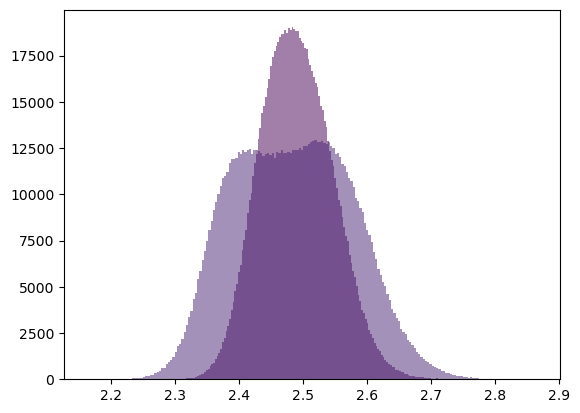

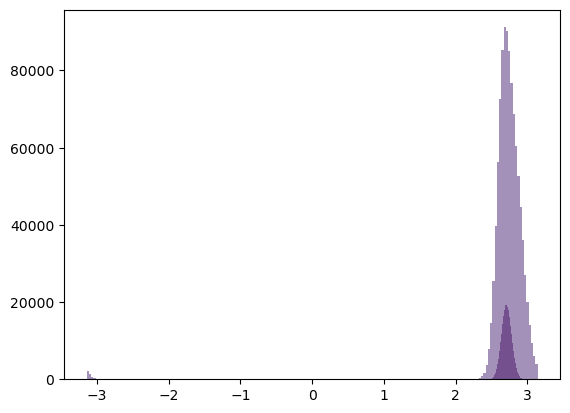

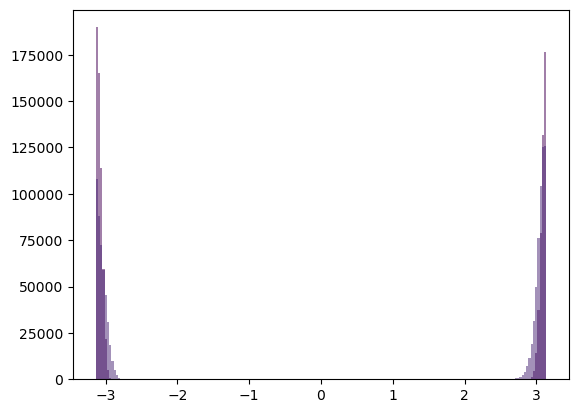

/tmp/ipykernel_248049/2913813960.py:196: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-k * (x - 1))) - 0.5 * a


Correlation time for set 0 is 218.0


/tmp/ipykernel_248049/2913813960.py:229: RuntimeWarning: overflow encountered in power
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3


Correlation time for set 1 is 94.0
Correlation time for set 2 is 88.0
Correlation time for set 3 is 478.0
Correlation time for set 4 is 452.0


Correlation time for set 5 is 408.0
no reversing of (decorrelated) Energy data is undertaken
reversing the (decorrelated) Energy data before calculations...


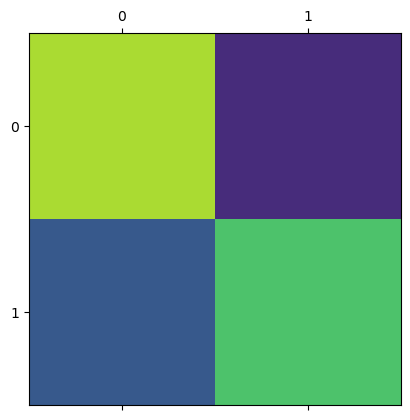

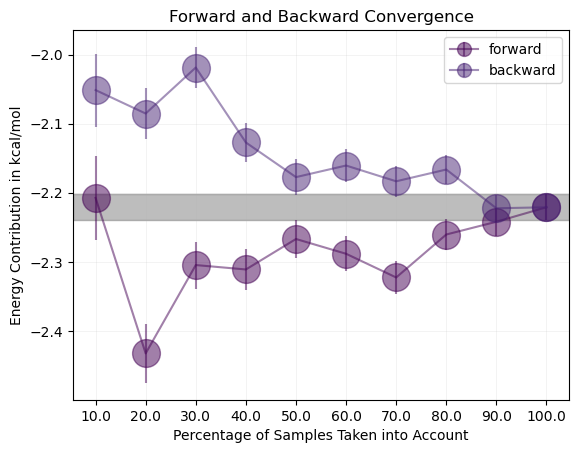

NameError: name 'ARW_FE_dict' is not defined

In [9]:
calculate_dG_oS()

## $ \Delta G^\text{S}_\text{a}$

In [11]:
def calculate_dG_aS():
    fileglob = '../_sim/10*/_output/pmd_pno*.txt'
    dG_aS = ARW_FE_analysis(fileglob, [6,7], 300, 100)
    dG_aS.read_cvdata_from_pmdout()
    dG_aS.plot_histograms(angularData=False)
    dG_aS.calc_MBAR_free_energy_differences_MultiCV(decorrelationRequired=True,
                                                    angularData=True,
                                                    minimumIndependentCVs=100,
                                                    showBSEplots=False)
    MbarOverlap = dG_aS.compute_overlap_matrix()
    dG_aS_dataloader = BlockedFES_Dataloader(dG_aS, 10, angularData=True)
    dG_aS_Blocked = BlockedMBARContributionEstimator(dG_aS_dataloader)
    dG_aS_Blocked.calculateBlockedContribution('forward')
    dG_aS_Blocked.calculateBlockedContribution('backward')
    dG_aS_Blocked.generateForwardBackwardConvergencePlot()
    ARW_FE_dict[r'$ \Delta G^\text{S}_\text{a}$'] = [dG_aS.Delta_F.min(), dG_aS.Delta_F_Error.max()]

## $ \Delta G^\text{B}_\text{o} = -k_\text{B} T \ln \left( \frac{1}{8\pi^2} \int_{0}^{\pi} \sin(\Theta) \, d\Theta \int_{0}^{2\pi} d\Phi \int_{0}^{2\pi} d\Psi \, e^{-\beta u_o(\Theta,\Phi,\Psi)} \right)$


In [12]:
def calculate_dG_oB():
    fileglob = '../_sim/01*/_output/pmd_pnoa.txt'
    dG_oB = ARW_FE_analysis(fileglob, [3,4,5], 300, 100)
    dG_oB.read_cvdata_from_pmdout()
    dG_oB.calc_G_oB()
    ARW_FE_dict[r'$ \Delta G^\text{B}_\text{o} $'] = [dG_oB.dG_oB, dG_oB.dG_oB_Error]

## $ \Delta G^\text{B}_\text{p}$

In [13]:
def calculate_dG_pB():
    fileglob = '../_sim/0[5,9]*/_output/pmd_prod_pBhreus*.txt'
    dG_pB = ARW_FE_analysis(fileglob, [1], 300, 50)
    dG_pB.read_cvdata_from_pmdout()
    dG_pB.calc_free_energies(decorrelationRequired=True, minimumIndependentCVs=100, showBSEplots=False)
    dG_pB.create_PMF(show_pmf=True)
    dG_pB.plot_histograms()
    dG_pB_overlap = dG_pB.compute_overlap_matrix()
    dG_pB_dataloader = BlockedFES_Dataloader(dG_pB, blockCount=10)
    dG_pB_Blocked = BlockedPMFcontributionEstimator(dG_pB_dataloader)
    dG_pB_Blocked.calculateBlockedContribution(1,5,'forward')
    dG_pB_Blocked.calculateBlockedContribution(1,5,'backward')
    dG_pB_Blocked.generateForwardBackwardConvergencePlot()
    ARW_FE_dict[r'$ \Delta G^\text{B}_\text{p}$'] = [dG_pB_Blocked.forwardContribution[-1], dG_pB_Blocked.forwardContribution_Error[-1]]

## $ \Delta G^\text{B}_\text{n}$

In [14]:
def calculate_dG_nB():
    fileglob = '../_sim/06*/_output/pmd_prod_nBhreus*.txt'
    dG_nB = ARW_FE_analysis(fileglob, [1], 300, 50)
    dG_nB.read_cvdata_from_pmdout()
    dG_nB.calc_free_energies(decorrelationRequired=True, minimumIndependentCVs=100, showBSEplots=False)
    dG_nB.create_PMF(show_pmf=True)
    dG_nB.plot_histograms()
    dG_nB_overlap = dG_nB.compute_overlap_matrix()
    dG_nB.calc_PMFcontribution(1, 5)
    dG_nB_dataloader = BlockedFES_Dataloader(dG_nB, blockCount=10)
    dG_nB_Blocked = BlockedPMFcontributionEstimator(dG_nB_dataloader)
    dG_nB_Blocked.calculateBlockedContribution(1,5,'forward')
    dG_nB_Blocked.calculateBlockedContribution(1,5,'backward')
    dG_nB_Blocked.generateForwardBackwardConvergencePlot()
    ARW_FE_dict[r'$ \Delta G^\text{B}_\text{n}$'] = [dG_nB_Blocked.forwardContribution[-1], dG_nB_Blocked.forwardContribution_Error[-1]]

## $ S^*= \left(r^*\right)^2 \int_{0}^{\pi} \sin(\theta) d\theta \int_{0}^{2\pi} d\phi e^{-\beta u_a(\theta,\phi)} $


In [15]:
def calculate_S_star():
    fileglob = '../_sim/10*/_output/pmd_pnoa.txt'
    S_star = ARW_FE_analysis(fileglob, [6,7], 300, 100)
    S_star.read_cvdata_from_pmdout()
    S_star.calc_S_star(r_star=30.23135)

## $ I^*$

In [16]:
def calculate_I_star():
    fileglob = '../_sim/11*/_output/pmd_prod_hreus*.txt'
    SeparationContribution = ARW_FE_analysis(fileglob, [8], 300, 100)
    SeparationContribution.read_cvdata_from_pmdout()
    SeparationContribution.calc_free_energies(decorrelationRequired=True, minimumIndependentCVs=100, showBSEplots=False)
    SeparationContribution.plot_histograms()
    SeparationContribution.create_PMF()
    SeparationContribution_overlap = SeparationContribution.compute_overlap_matrix()
    SeparationContribution_dataloader = BlockedFES_Dataloader(SeparationContribution, blockCount=10)
    SeparationContribution = BlockedIstar_estimator(SeparationContribution_dataloader, 30, S_star.S_star, S_star.S_star_Error)
    SeparationContribution.calculateBlockedContribution('forward')
    SeparationContribution.calculateBlockedContribution('backward')
    SeparationContribution.generateForwardBackwardConvergencePlot()
    ARW_FE_dict[r'$-k_\text{B} T \ln\left(I^* S^* C^\text{o} \right)$'] = [SeparationContribution.backwardSeparationEnergies[-1], SeparationContribution.backwardSeparationEnergies_Error[-1]]

reading file with the filename ../_sim/10_TIP3P_med_site_NewRefCV/_output/pmd_p.txt
reading file with the filename ../_sim/10_TIP3P_med_site_NewRefCV/_output/pmd_.txt


/tmp/ipykernel_1061372/2913813960.py:107: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0)))
/tmp/ipykernel_1061372/2913813960.py:196: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-k * (x - 1))) - 0.5 * a


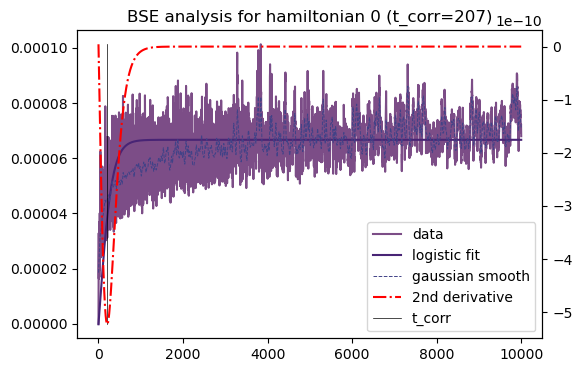

Correlation time for set 0 is 414.0


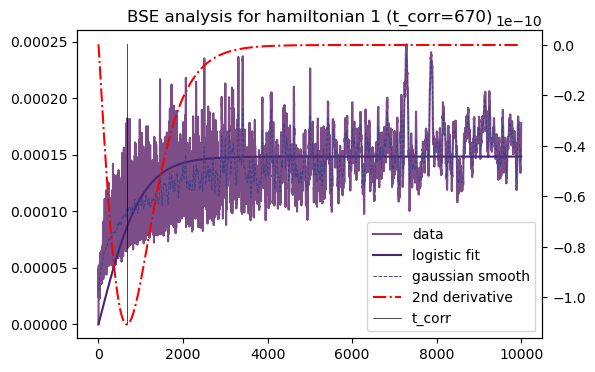

Correlation time for set 1 is 1340.0


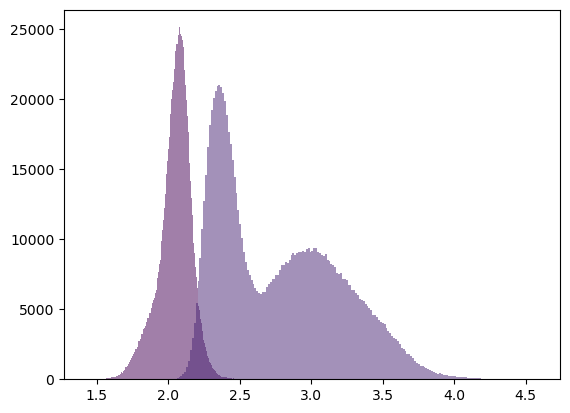

no reversing of (decorrelated) Energy data is undertaken
reversing the (decorrelated) Energy data before calculations...


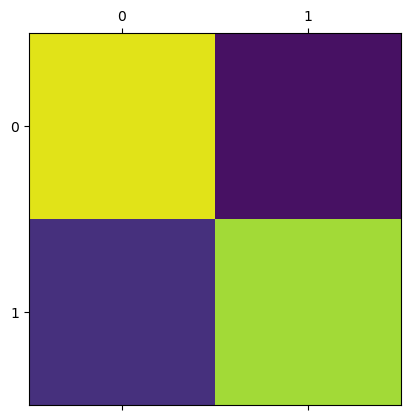

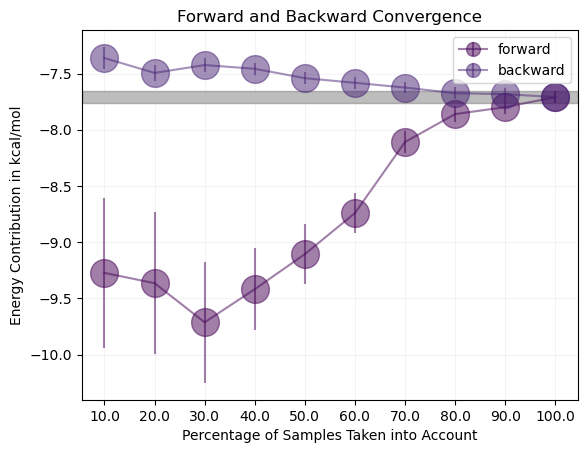

reading file with the filename ../_sim/10_TIP3P_med_site_NewRefCV/_output/pmd_pno.txt
reading file with the filename ../_sim/10_TIP3P_med_site_NewRefCV/_output/pmd_pnoa.txt


/tmp/ipykernel_1061372/2913813960.py:155: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0)))


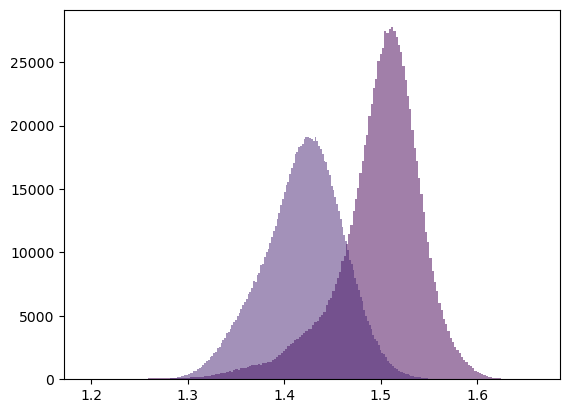

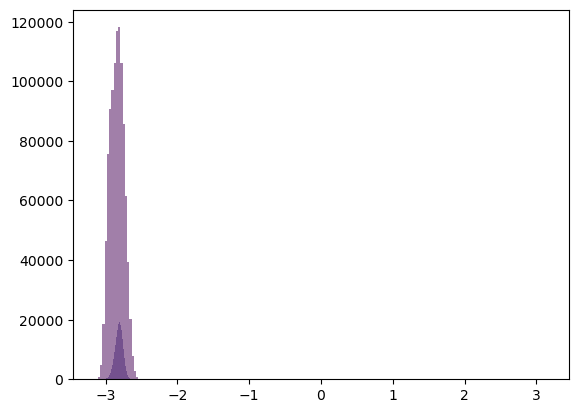

/tmp/ipykernel_1061372/2913813960.py:196: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-k * (x - 1))) - 0.5 * a


Correlation time for set 0 is 464.0
Correlation time for set 1 is 364.0
Correlation time for set 2 is 414.0
Correlation time for set 3 is 236.0
no reversing of (decorrelated) Energy data is undertaken
reversing the (decorrelated) Energy data before calculations...


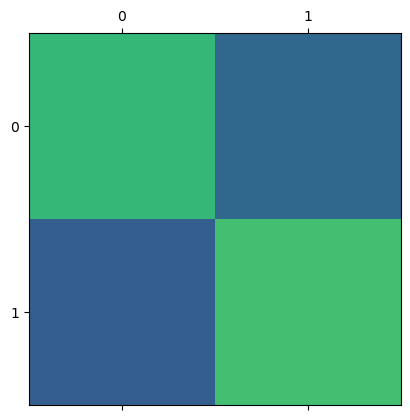

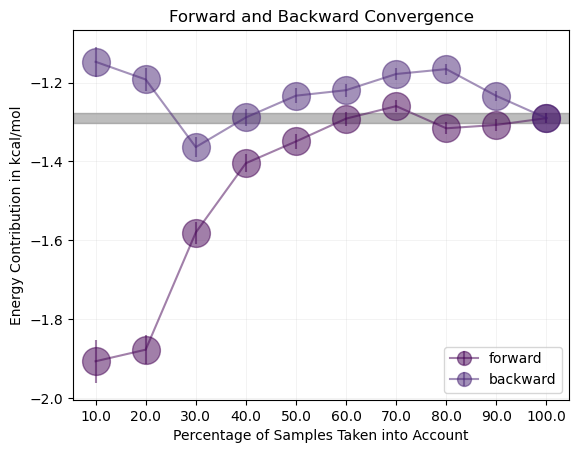

reading file with the filename ../_sim/10_TIP3P_med_site_NewRefCV/_output/pmd_pn.txt
reading file with the filename ../_sim/10_TIP3P_med_site_NewRefCV/_output/pmd_p.txt


/tmp/ipykernel_1061372/2913813960.py:107: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0)))


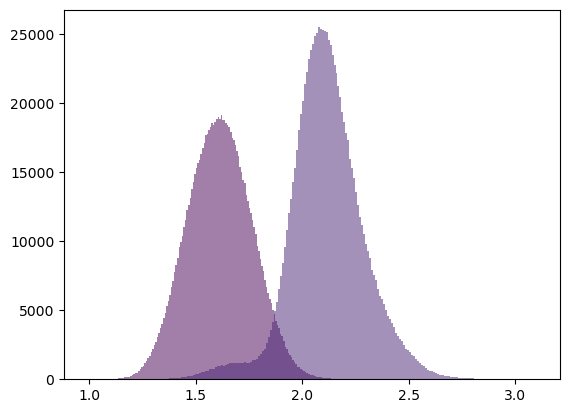

no reversing of (decorrelated) Energy data is undertaken
reversing the (decorrelated) Energy data before calculations...


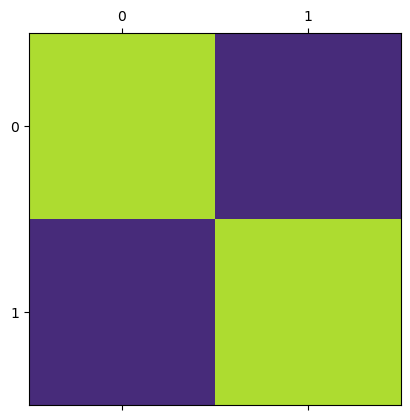

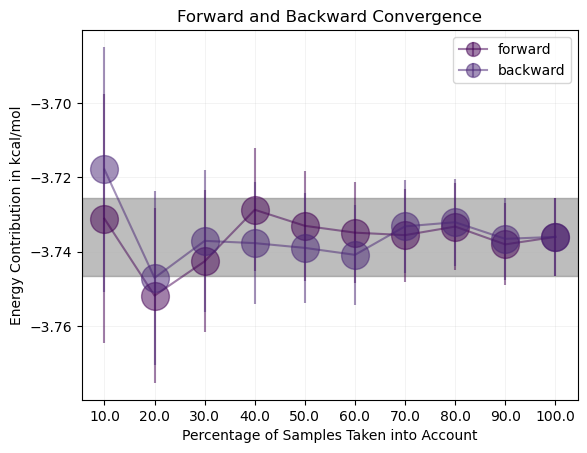

reading file with the filename ../_sim/10_TIP3P_med_site_NewRefCV/_output/pmd_pno.txt
reading file with the filename ../_sim/10_TIP3P_med_site_NewRefCV/_output/pmd_pn.txt


/tmp/ipykernel_1061372/2913813960.py:155: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0)))


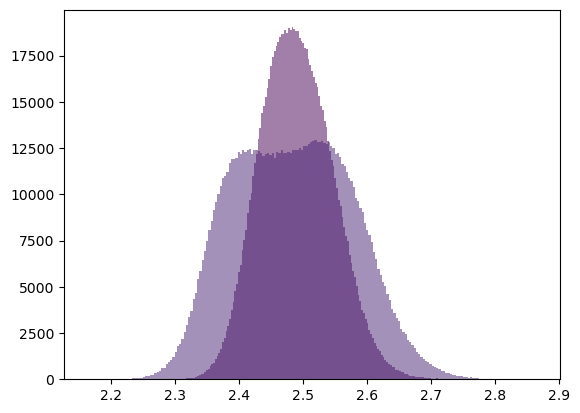

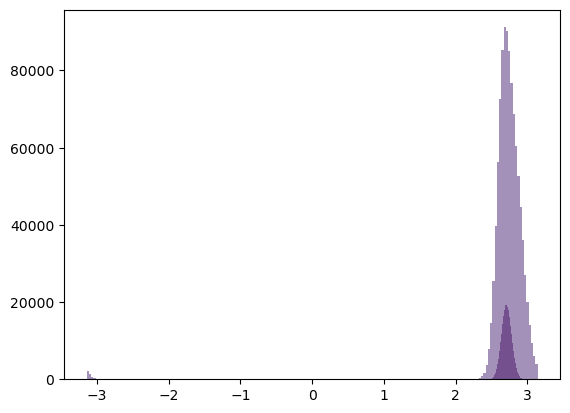

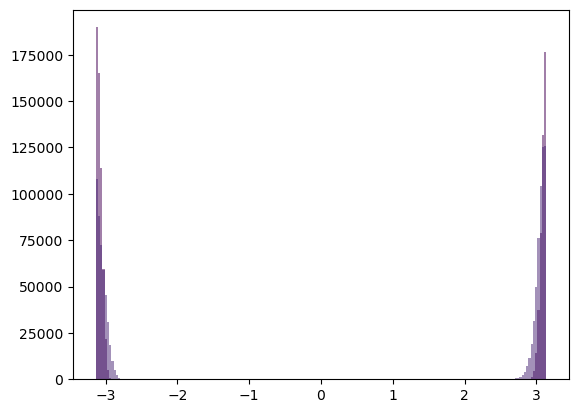

/tmp/ipykernel_1061372/2913813960.py:196: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-k * (x - 1))) - 0.5 * a


Correlation time for set 0 is 218.0


/tmp/ipykernel_1061372/2913813960.py:229: RuntimeWarning: overflow encountered in power
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3


Correlation time for set 1 is 94.0
Correlation time for set 2 is 88.0
Correlation time for set 3 is 478.0
Correlation time for set 4 is 452.0
Correlation time for set 5 is 408.0
no reversing of (decorrelated) Energy data is undertaken
reversing the (decorrelated) Energy data before calculations...


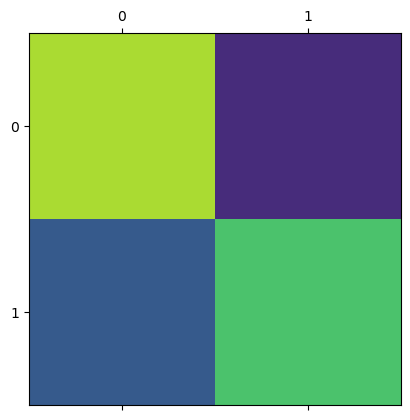

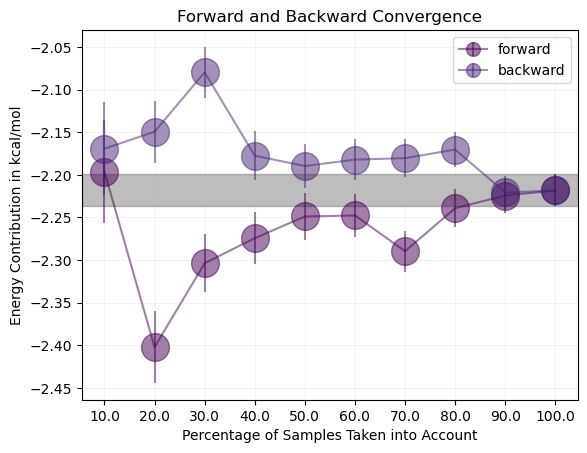

reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus11.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus8.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus14.0.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus5.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus10.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus9.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus15.0.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus6.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus13.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus7.5.txt
reading file with the filename ../_

/tmp/ipykernel_1061372/2913813960.py:107: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0)))
/tmp/ipykernel_1061372/2913813960.py:196: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-k * (x - 1))) - 0.5 * a
/tmp/ipykernel_1061372/2913813960.py:229: RuntimeWarning: overflow encountered in power
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3


Correlation time for set 0 is 104.0


/tmp/ipykernel_1061372/2913813960.py:229: RuntimeWarning: overflow encountered in multiply
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3
/tmp/ipykernel_1061372/2913813960.py:229: RuntimeWarning: invalid value encountered in divide
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3


Correlation time for set 1 is 50.0
Correlation time for set 2 is 56.0
Correlation time for set 3 is 66.0
Correlation time for set 4 is 76.0
Correlation time for set 5 is 56.0
Correlation time for set 6 is 80.0
Correlation time for set 7 is 94.0
Correlation time for set 8 is 102.0
Correlation time for set 9 is 138.0
Correlation time for set 10 is 146.0
Correlation time for set 11 is 106.0
Correlation time for set 12 is 76.0
Correlation time for set 13 is 100.0
Correlation time for set 14 is 94.0
Correlation time for set 15 is 990.0
Correlation time for set 16 is 312.0
Correlation time for set 17 is 636.0
Correlation time for set 18 is 660.0
Correlation time for set 19 is 604.0
Correlation time for set 20 is 398.0
Correlation time for set 21 is 264.0
Correlation time for set 22 is 300.0
Correlation time for set 23 is 216.0
Correlation time for set 24 is 120.0
Correlation time for set 25 is 128.0
Correlation time for set 26 is 252.0
Correlation time for set 27 is 126.0
Correlation time fo

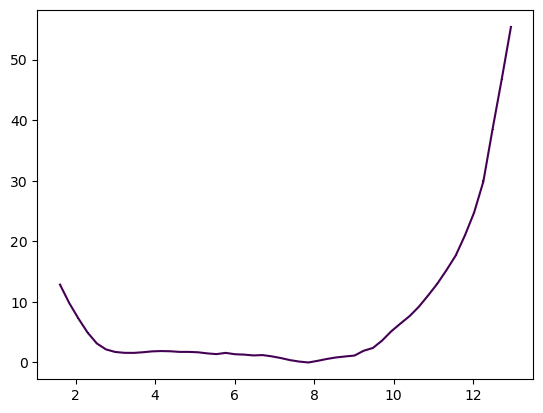

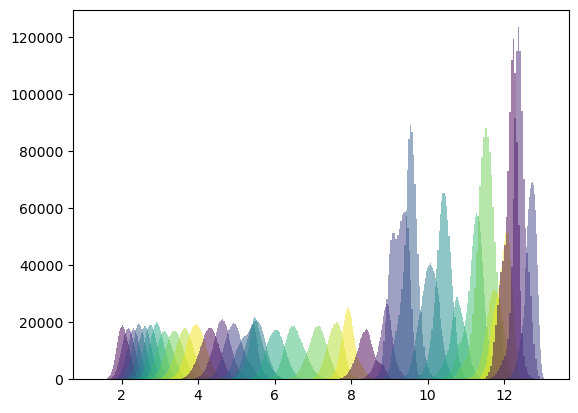

no reversing of (decorrelated) Energy data is undertaken
reversing the (decorrelated) Energy data before calculations...


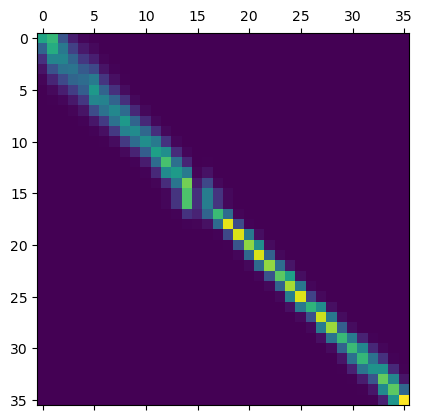

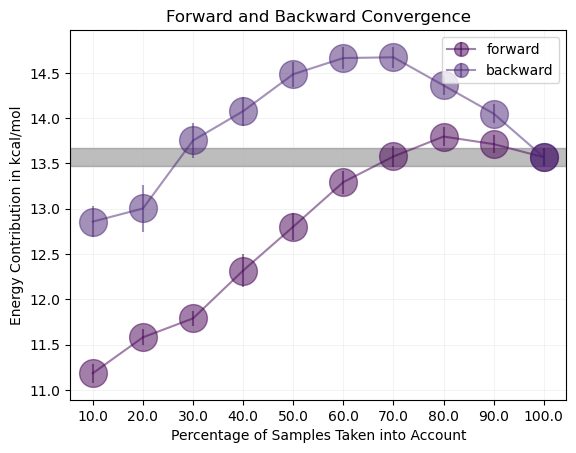

reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus4.3.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus3.7.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus1.6.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus1.9.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus1.0.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus3.1.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus5.2.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus2.8.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus5.5.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus2.5.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBh

/tmp/ipykernel_1061372/2913813960.py:107: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0)))
/tmp/ipykernel_1061372/2913813960.py:196: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-k * (x - 1))) - 0.5 * a


Correlation time for set 0 is 158.0


/tmp/ipykernel_1061372/2913813960.py:229: RuntimeWarning: overflow encountered in multiply
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3
/tmp/ipykernel_1061372/2913813960.py:229: RuntimeWarning: overflow encountered in power
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3
/tmp/ipykernel_1061372/2913813960.py:229: RuntimeWarning: invalid value encountered in divide
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3


Correlation time for set 1 is 66.0
Correlation time for set 2 is 62.0
Correlation time for set 3 is 80.0
Correlation time for set 4 is 104.0
Correlation time for set 5 is 128.0
Correlation time for set 6 is 130.0
Correlation time for set 7 is 140.0
Correlation time for set 8 is 146.0
Correlation time for set 9 is 222.0
Correlation time for set 10 is 172.0
Correlation time for set 11 is 180.0
Correlation time for set 12 is 206.0
Correlation time for set 13 is 120.0
Correlation time for set 14 is 118.0
Correlation time for set 15 is 400.0
FES succesfully calculated


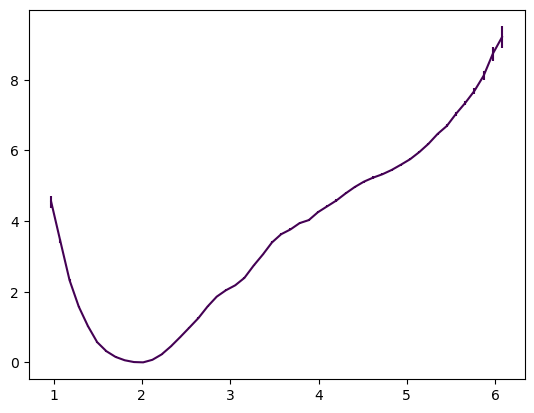

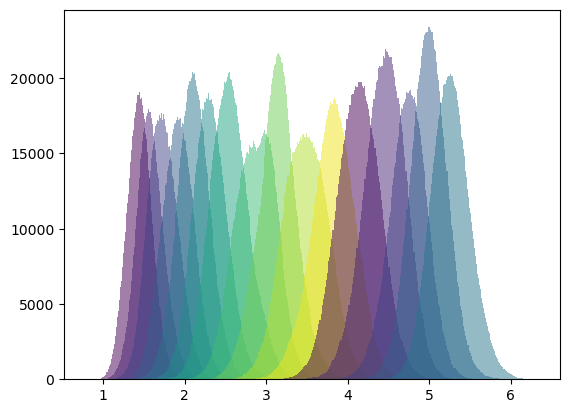

no reversing of (decorrelated) Energy data is undertaken
reversing the (decorrelated) Energy data before calculations...


KeyError: (0,)

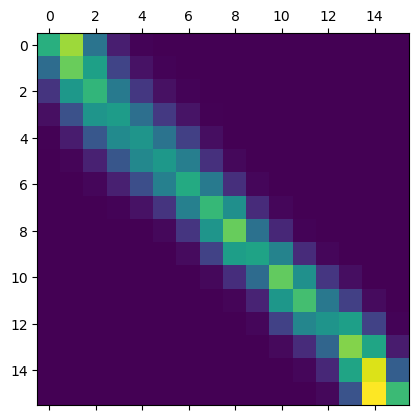

In [19]:
def main():
    global ARW_FE_dict
    ARW_FE_dict = {}
    
    calculate_dG_pS()
    calculate_dG_aS()
    calculate_dG_nS()
    calculate_dG_oS()
    calculate_dG_pB()
    calculate_dG_nB()
    calculate_dG_oB()
    calculate_S_star()
    calculate_I_star()
    
    ARW_FE_df = pd.DataFrame.from_dict(ARW_FE_dict).transpose()
    ARW_FE_df.columns = [['Value','Error']]
    ARW_FE_df.loc[r'$\Delta G_\text{bind}^o$',:] = ARW_FE_df['Value'].sum()[0], ARW_FE_df['Error'].sum()[0] 

    texID = time.strftime("%Y_%m_%d_%H-%M-%S")
    ARW_FE_df.to_latex('../_output/DAT/ARW_FE_tip3p_med_{}.tex'.format(texID))
    ARW_FE_df
    
if __name__ == '__main__':
    main()